# Demonstration of using direct (real-space) convolutions in scarlet

## Introduction
The purpose of this notebook is to serve as a simple model to demonstrate how we can implement direct convolutions in scarlet in place of the current FFT convolutions. While designing this change I came across a few other changes that we can make to improve the speed of the code and potentially its memory footprint, while also lessening (or altogether eliminating) our dependence on autograd (or pytorch or jax). The other purpose is to remind my future self why I made some of the design choices that I made and give Peter and Remy the opportunity to correct and improve any elements of the design.

### Gradients
Let's start by thinking about why we switched to automatic gradients in the first place. We have a fairly simple model, where each extended source can be modeled as

$M_k = A_k \cdot S_k$

where $M_k$ is the model for the $k^{th}$ component, $A_k$ is its amplitude and $S_k$ is its shape. So the model for the entire blend of $K$ components is

$ M = \sum_{k=1}^{K}{M_k}$.

Given our data $D$ and weights $W$ our model without convolution is

$ \mathcal{L} = \frac{1}{2}W\cdot(D-M)^2$

and with convolutions is

$ \mathcal{L}_C = \frac{1}{2}W\cdot(D-P(M))^2$

where $P(M)$ is a function that performs a convolution on the entire model $M$. This function can be a direct analytic convolution like we first used in scarlet or a more complicated (to write) DFT.

So initially we calculated the gradient of this model analytically by writing $\mathcal{L}$ as 

$ \mathcal{L} = \frac{1}{2}W\cdot(D-\sum_{k=1}^{K}{A\cdot S})^2$

and calculating the entire derivative in one step. Even when we introduced a PSF we derived a rather pathalogical formula to apply the PSF that involved using a large tensor for $P$ that still allowed us to calculte the gradient in a single step. But once we switched to DFT convolutions on the entire image it became much more difficult to write an analytic gradient, especially knowing that our component models might get more complex, so we elected to use automatic gradients to speed up development. The other side benefit of using this method is that now our models could become more complex, as we didn't have to calcualte a complex derivative based on all of our parameters, for example our `PointSource` model became possible, as well as a future multiplicative models for dust.

I think that this was the right thing to do and in general a good practice, as using autograd has certainly sped up development time, but using it comes with an overhead. This mostly involves the cpu time and memory necessary to generate the tree used by autograd to track each parameter so that it can properly be updated when the `grad` method is called. But looking back on what autograd actually does I think that it's time to implement a hybird approach to our gradients by thinking about what autograd does internally.

Instead of attempting to calcualte the entire gradient in a single step, autograd would take our $\mathcal{L}_C$ model above and use the chain rule. So to calculate the gradient of $A_i$ for model $i$ we would use

$\frac{\partial\mathcal{L}_C}{\partial A_i} = \frac{\partial\mathcal{L}_C}{\partial P(M)} \frac{\partial P(M)}{\partial M} \frac{\partial M}{\partial M_i} \frac{\partial M_i}{\partial A_i}$.

So even when using DFTs for $P(M)$ we can analytically calculate all of the partial derivatives except for $\frac{\partial P(M)}{\partial M}$, meaning we could significantly simplify the models we pass to autograd by calculating all of the known gradients and only using autograd to differntialte through the DFT.

By switching to direct convolutions we can even calculate this term, so it is possible to build our gradient entirely analytically in the case where $\frac{\partial M_k}{\partial x_k}$ is simple for some parameter $x_k$. In many cases we can still calculate $\frac{\partial M_k}{\partial x_k}$ analytically, it will just be different than the usual $A_k$ and $S_k$ gradients. However, in cases where our initial model is complex and calculating the analytic gradient is either impossible or cumbersome (for example our `PointSource` model), we can implement whatever automatic gradient code the user chooses to calculate the gradients of only the $\frac{\partial M_k}{\partial x_k}$ term. This gives us the benefit of speeding up runtime by giving autograd easier tasks but allowing us the flexibility to use autograd to quicky test a new model without too much analytic work to slow us down.

### Direct convolutions in boxes

This notebook also shows three different methods to calculate direct convolutions. All three methods are equally simple to implement and will be discussed in the next section, this section just holds the justification for using method 3 (hereafter refered to as the box method). This is similar to the calculation posted in slack (so feel free to skip to [Design](#Design)) only now I compare the following models:

1. direct convolutions using autograd
1. direct convolutions without autograd
1. direct convolutions without autograd using the box method

We first define the following:
* $S$ = average area of a stamp
* $I$ = Area of the entire image
* $P$ = Area of the PSF
* $k$ = number of sources in the image

#### Method 1 (autograd)

First we’ll look at using the current method but replacing the FFTs with convolutions in real space and the cost of each computation:
Forward path:
* First we have to pad each model from $S\rightarrow I$: ~$kS$ operations
* Sum all of the models together: $kI$ operations
* Convolve the entire image with the PSF: $PI$ operations

Backward path:
* Derivative of the convolution operation for all pixels in the image: $PI$ operations
* Derivative of the sum: $kI$ operations
* Extract the box for each model: $kS$ operations

**Total number of operations: $2(PI+kI+kS)$**

#### Method 2 (without autograd)

Now that we eliminate autograd we no longer have to pad our models and sum them in the image frame so we have significant savings:

Forward Path:
* Insert each model into the larger model (we don’t have to pad now since we don’t need autograd to do the derivative, we can just update a slice): $kS$ operations
* Convolve the entire image with the PSF (same as before): $PI$ operations

Backward Path:
* Derivative of the convolution operation for all pixels in the image: $PI$ operations
* Extract the box for each model: $kS$ operations

**Total number of operations: $2(PI+kS)$**

#### Method 3 (box method)

Now lets look at the box method, where we can update each box individually.

Forward path: same as method 2

Backward path:
* Extract the region from the derivative for each source: kSP operations

**Total number of operations: $PI + kS + kSP$**

#### Comparison

The difference between method 1 and method 2 is $2kI$, which is substantial for large images with a large number of sources while the improvement from method 2 to method 3 is $P(I-kS) + kS$. The dominant term is the difference between the image area $I$ and the area of all the sources in the _model frame_, which should nearly always be smaller since most sources don't overlap in the model frame. In instances where they are nearly the same $kS$ will still offer a small savings for large images (imagine a 1k X 1k blend with 100's of sources, which we do see in some of the HSC deep fields). For such small savings it might be worth sticking with method 2, with the possibility of using FFT convolutions in the forward frame and only using the analytic convolutions in the backpropagation.

## Design

As stated in [Gradients](#Gradients) the main design change I am suggesting is to analytically calculate the first two partial derivatives in

$\frac{\partial\mathcal{L}_C}{\partial x_i} = \frac{\partial\mathcal{L}_C}{\partial P(M)} \frac{\partial P(M)}{\partial M} \frac{\partial M}{\partial M_i} \frac{\partial M_i}{\partial x_i}$

ouselves, and leave it up to the model (and individual components) to calculate $\frac{\partial M}{\partial M_i} \frac{\partial M_i}{\partial x_i}$ for each model parameter $x_i$.

I've identified the following changes to the code, which should be sufficient to implement this design:

### General changes

* `autograd` will be removed as a required dependency and all modules will `import numpy as np` except `fft.py`, which will still use autograd array boxes to allow us to backpropagate through FFTs if necessary (for example with shifting). However, if fft and ifft are the only methods that we use autograd for it might be useful to just implement those gradients ourselves too, although I can't say for sure how difficult that would be.

### parameter.py

I start with this module because it is the most confusing, mainly because I don't fully understand how `ArrayBox.register` works. Ideally we'd like to have a `Parameter` that is just a `numpy.array` with the added methods required by `AdaProx` to calculate gradients, since in the canonical case I don't think that we'll need autograd anymore. So I *think* that the following changes will be sufficient to make it possible to have autograd compatible parameters and autograd incompatible parameters (normal arrays) but I'd like Peter to confirm:
* Keep `Parameter` as is
* Create a new `AutogradParameter` that inherits from `Parameter`. Then in `parameter.py` we will use `ArrayBox.register(AutogradParameter)` and `VSpace.register(AutogradParameter, vspace_maker=Vspace.mappings[np.ndarray])`. This way ordinary models will have `Parameters` whose gradients will be updated by `AdaProx` while only the parameters that require autograd will use `AutogradParameter` (which I don't see being used much anymore except when testing out new models).

Side note: shoud `parameter.py` be moved to `proxmin`? There isn't anything scarlet specific in here and this might prove useful to people using `proxmin` for optimization. This would also require a check as to whether or not autograd (or jax?) is installed to register the array box, and likely a setup option to decide which to use if they are both installed.

### blend.py

* `Blend.fit` will need to send a different `grad` function:
    * Each observation will return either $\frac{\partial\mathcal{L}_C}{\partial M}$ or $\frac{\partial\mathcal{L}_C}{\partial P(M)}$ (see [observation.py](#observation.py)) that is the shape of the model frame.
    * Methods 1 and 2
        * The slice of $\frac{\partial\mathcal{L}_C}{\partial M}$ contained in each `Component.frame` is passed to
          `Component.grad`.
    * Box Method
        * Each `Component` has only the pixels in its frame convolved  to calculate
          $\frac{\partial P(M)}{\partial M}$ and the result of $\frac{\partial\mathcal{L}_C}{\partial P(M)} \frac{\partial P(M)}{\partial M}$ is passed to `Component.grad`.
    * The result of `Component.grad` for all components is returned as a tuple (the same as the current implementation)

### observation.py

* We first calculate $\frac{\partial\mathcal{L}_C}{\partial P(M)} = -W\cdot(D-P(M))$
* Method 1 (with autograd)
    * We create an `ArrayBox` for the model during `render` that is stored in the observation.
      When `Observation.grad` is called we use autograd to calculate $\frac{\partial P(M)}{\partial M}$ and multiply
      that with $\frac{\partial\mathcal{L}_C}{\partial P(M)}$ and return $\frac{\partial\mathcal{L}_C}{\partial M}$.
    * This will also allow us to use autograd for the multi-resolution observations
* Method 2
    * Both $\frac{\partial\mathcal{L}_C}{\partial P(M)}$ and $\frac{\partial P(M)}{\partial M}$ are calculated
      analytically in `Observation.grad` and returned, as in method 1.
* Box method
    * Only $\frac{\partial\mathcal{L}_C}{\partial P(M)}$ is calculated and returned from `Observation.grad`,
      where `Blend.grad` will calculate $\frac{\partial P(M)}{\partial M_i}$ for each component model $M_i$.

### component.py

* `Component`
    * Will now contain a `grad` method that must be overridden in inherited classes.
      `grad` takes the upstream gradients as an argument, the same as autograd,
      and calculates $\frac{\partial M_i}{\partial x_i}$ for each parameter $x_i$,
      returning the result as a tuple.
    * `get_model` will no longer pad, as `blend.get_model` will insert the model for each component into
      an image the size of `blend.frame`.
* `FactorizedComponent`
    * All of the `_pad_...` methods will be removed
    * `grad` will analytically calculate $\frac{\partial M_i}{\partial A_i}$ and $\frac{\partial M_i}{\partial S_i}$
      and return a tuple with the total gradient updates for $A_i$ and $S_i$ (and the shift parameters if necessary)
    * With `shift=True`
        * `get_model` will build the model and store that in an `ArrayBox`, which is then shifted in k-space
          and returned
        * `grad` will use autograd to calculate $\frac{\partial M_i}{\partial shift_y}$
          and $\frac{\partial M_i}{\partial shift_x}$
* `FunctionComponent`
    * `get_model` will build the model from the parameters exactly as before
    * By default `grad` will assume that the parameters are `AutogradParameter`s and
      calcualate $\frac{\partial M_i}{\partial x_i}$ for each parameter.
      This can be overridden by inherited classes with a known gradient.

* `ComponentTree`
    * For now all of our models are additive and have equal weight, so $\frac{\partial M}{\partial M_i} = 1$.
    * This makes `grad` easy, since it will just pass the result of $\frac{\partial\mathcal{L}_C}{\partial M}$
      through to `Component.grad` for each component
    * `get_model` is similar, except that now have two different case:
        1. All of the components have the same frame
            * In this case `get_model` can easily add all of the models together and return the result
        1. Some components have different frames
            * In this case we need to create a new frame for the `ComponentTree` that is the minimum size needed
              to contain all of its components and return that in `get_model`.
            * `grad` will now need to pass only the correct slice of each gradient through to its components
            * `set_frame` will not pass the frame to its children, since they are already different sizes.

### source.py

* The only changes to `ExtendedSource` and `MultiComponentSource` is that if `shifting=True` then the shift will be a `AutogradParameter`, since `FactorizedComponent` and `ComponentTree` will implement all of the necessary upgrades to calcualte $\frac{\partial M_i}{\partial A_i}$ and $\frac{\partial M_i}{\partial S_i}$
* `PointSource` will also remain unchanged for now, since implementing an analytic derivative to shift the PSF requires knowlege of the PSF function. Since we are likely to continue using gaussian PSFs in the future it may be worth our while to inherit from `PointSource` with a class that implements a gaussian PSF and an analytic gradient.

### psf.py

* `autograd.numpy` and `autograd.scipy` will be moved into the `gaussian` and `moffat` functions, since those are the only ones required to be compatible with autograd (because of `PointSource`).

# Test methods 1 and 2 for speed

We use a toy model to test what the speed improvement is using autograd vs analytic gradients. The first step is making sure that our toy model works with a small PSF and image that is easy to check

In [1]:
from functools import partial

import autograd.numpy as np
#from autograd import grad
from autograd.extend import defvjp, primitive
from autograd import elementwise_grad as grad
import matplotlib.pyplot as plt

import scarlet
from scarlet.operators_pybind11 import apply_filter

In [21]:
def get_filter_coords(filter_values, center=None):
    """Create filter coordinate grid needed for the apply filter function
    """
    if len(filter_values.shape)!=2:
        raise ValueError("`filter_values` must be 2D")
    if center is None:
        if filter_values.shape[0] % 2 == 0 or filter_values.shape[1] % 2 == 0:
            msg = """Ambiguous center of the `filter_values` array,
                     you must use a `filter_values` array
                     with an odd number of rows and columns or
                     calculate `coords` on your own."""
            raise ValueError(msg)
        center = [filter_values.shape[0]//2, filter_values.shape[1]//2]
    x = np.arange(filter_values.shape[1])
    y = np.arange(filter_values.shape[0])
    x,y = np.meshgrid(x,y)
    x -= center[1]
    y -= center[0]
    coords = np.dstack([y,x])
    return coords


def get_filter_slices(coords):
    """Get the slices in x and y to apply a filter
    """
    z = np.zeros((len(coords),), dtype=int)
    # Set the y slices
    y_start = np.max([z, coords[:,0]], axis=0)
    y_end = -np.min([z, coords[:,0]], axis=0)
    # Set the x slices
    x_start = np.max([z, coords[:,1]], axis=0)
    x_end = -np.min([z, coords[:,1]], axis=0)
    return y_start, y_end, x_start, x_end


def get_component_model(sed, morph, center):
    """Get a model for a single component
    """
    y,x = center
    box = (slice(y-1, y+2), slice(x-1, x+2))
    return sed[:, None, None]*morph[None, :, :], box

def grad_get_component_model(chain_grad, model, sed, morph, center):
    """Calculate the gradient for a single component model
    
    This is dM/dM_i from the introduction.
    """
    y,x = center
    box = (slice(y-1, y+2), slice(x-1, x+2))
    _chain_grad = chain_grad[:, box[0], box[1]]
    sed_grad = np.einsum("...jk,jk", _chain_grad, morph)
    morph_grad = np.einsum("i,i...", sed, _chain_grad)
    return sed_grad, morph_grad


def get_full_model(seds, morphs, centers, shape):
    """Combine all of the single component models into one model
    """
    model = np.zeros(shape)
    boxes = []
    for k in range(len(seds)):
        _model, box = get_component_model(seds[k], morphs[k], centers[k])
        model[:, box[0], box[1]] += _model
        boxes.append(box)
    return model, box

def grad_get_full_model(chain_grad, model, centers, seds, morphs):
    """Collect the gradients of all the single component models
    
    This would also multiply by dM/dM_i,
    except that all models have equal weights so `dM/dM_i=1`.
    """
    sed_grads = []
    morph_grads = []
    for k in range(len(centers)):
        grads = grad_get_component_model(chain_grad, model, seds[k], morphs[k], centers[k])
        sed_grads.append(grads[0])
        morph_grads.append(grads[1])
    return np.array(sed_grads), np.array(morph_grads)

def a_get_full_model(seds, morphs, centers, shape):
    """Autograd implementation of grad_get_full_model
    
    This is similar to `get_full_model` except that we
    have to pad the model for each source in order to
    sum them together in a way that autograd understands.
    This is likely where the majority of our cpu savings
    come from.
    """
    model = np.zeros(shape)
    boxes = []
    for k in range(len(seds)):
        _model, box = get_component_model(seds[k], morphs[k], centers[k])
        pad_width = list((
                max(0, b.start),
                max(0, model.shape[n+1]-b.stop),
            )
            for n, b in enumerate(box)
        )
        _model = np.pad(_model, [(0,0)] + pad_width,mode="constant", constant_values=0)
        model += _model
        boxes.append(box)
    return model, box

@primitive
def convolve(image, psf, slices):
    """Convolve an image with the PSF
    """
    result = np.empty(image.shape, dtype=image.dtype)
    for band in range(len(image)):
        if hasattr(image[band], "_value"):
            # This is an ArrayBox
            img = image[band]._value
        else:
            img = image[band]
        apply_filter(img, psf.reshape(-1), slices[0], slices[1], slices[2], slices[3], result[band])
    return result

def grad_convolve(input_grad, psf, slices):
    """Gradient of the convolution
    """
    return convolve(input_grad, psf[::-1, ::-1], slices)    

def a_grad_convolve(convolved, image, psf, slices):
    """Gradient of convolution for autograd
    
    Based on the autograd tutorial to implement your own gradients:
    https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
    """
    return lambda input_grad: convolve(input_grad, psf[::-1, ::-1], slices)

# Register this function in autograd
defvjp(convolve, a_grad_convolve)

def logL(data, model, weights=1):
    """Log-likelihood
    """
    return 0.5*weights*(data-model)**2

def grad_logL(data, model, weights=1):
    """Gradient of the log-likelihood
    """
    return weights*(model-data)

def a_loss(seds, morphs, image, psf, slices):
    """This is the method that autograd uses to calculate the gradients
    """
    model, boxes = a_get_full_model(seds, morphs, centers, image.shape)
    model = convolve(model, psf, slices)
    return logL(image, model)


def img2rgb(image):
    """Display an image as an array
    """
    rgb = image.copy()
    rgb[rgb>255] = 255
    rgb[rgb<0] = 0
    rgb = rgb.astype(np.uint8)
    rgb = np.transpose(rgb, axes=(1,2,0))
    return rgb

def build_scene(shape, K, psf, figsize=None, show=True):
    """Build an image and models for a collection of sources
    """
    B, N, M = shape
    images = np.zeros(shape)
    centers = np.zeros((K, 2), dtype=int)
    seds = np.zeros((K, B))
    morphs = np.zeros((K, 3, 3))
    morphs[:, 1, 1] = 1
    
    for k in range(K):
        morphs[k] = np.arange(9).reshape(3, 3)

    py = ((psf.shape[0]-1)//2)
    px = ((psf.shape[1]-1)//2)
    print(py, px)

    for k in range(K):
        cy = np.random.randint(psf.shape[0], images.shape[1]-psf.shape[0])
        cx = np.random.randint(psf.shape[1], images.shape[2]-psf.shape[1])
        center = np.array([cy, cx])
        sed = np.random.rand(B)
        sed *= 500/np.sum(sed)
        centers[k] = center
        y,x = center
        images[:, y-py:y+py+1, x-px:x+px+1] += psf[None, :, :] * sed[:,None,None]
        seds[k] = sed
    if show:
        rgb = img2rgb(images)
        if figsize is not None:
            plt.figure(figsize=figsize)
        plt.imshow(rgb)
        plt.show()
    return images, centers, seds, morphs

In [22]:
def calculate_autograd_gradients(images, centers, seds, morphs):
    # Initialize the autograd loss function
    _grad = grad(partial(a_loss, image=images, psf=psf, slices=slices), tuple(range(2)))
    g_auto = _grad(seds, morphs)
    
    return g_auto

def calculate_analytic_gradients(images, centers, seds, morphs):
    model, boxes = get_full_model(seds, morphs, centers, images.shape)
    convolved = convolve(model, psf, slices)

    gL = grad_logL(images, convolved)
    gLC = grad_convolve(gL, psf, slices)

    g_analytic = grad_get_full_model(gLC, model, centers, seds, morphs)
    return g_analytic

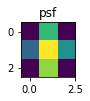

1 1


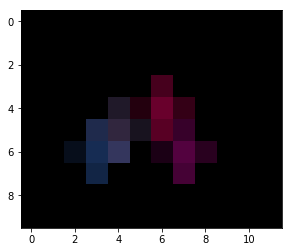

CPU times: user 3.07 ms, sys: 536 µs, total: 3.61 ms
Wall time: 3.38 ms
CPU times: user 615 µs, sys: 161 µs, total: 776 µs
Wall time: 679 µs


(3.637978807091713e-12, 0.0)

In [23]:
np.random.seed(1)

# Initialize a small PSF
units = 0.05
psf = np.array([[0,4,0],[2,6,3],[0,5,0]]) * units
_psf = psf[::-1, ::-1]

# get the coords and filter slices needed to 
coords = get_filter_coords(psf)
slices = get_filter_slices(coords.reshape(-1, 2))

plt.figure(figsize=(1,1))
plt.title("psf")
plt.imshow(psf)
plt.show()

K = 4
images, centers, seds, morphs = build_scene((3, 10, 12), K, psf)

%time g_auto = calculate_autograd_gradients(images, centers, seds/2, morphs)
%time g_analytic = calculate_analytic_gradients(images, centers, seds/2, morphs)
np.max(np.abs(g_auto[0]-g_analytic[0])), np.max(np.abs(g_auto[1]-g_analytic[1]))

In [24]:
g_auto[0] - g_analytic[0], g_auto[1] - g_analytic[1]

(array([[ 0.00000000e+00,  0.00000000e+00, -1.81898940e-12],
        [ 0.00000000e+00,  1.81898940e-12,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-3.63797881e-12, -1.13686838e-13,  0.00000000e+00]]),
 array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]))

1 1


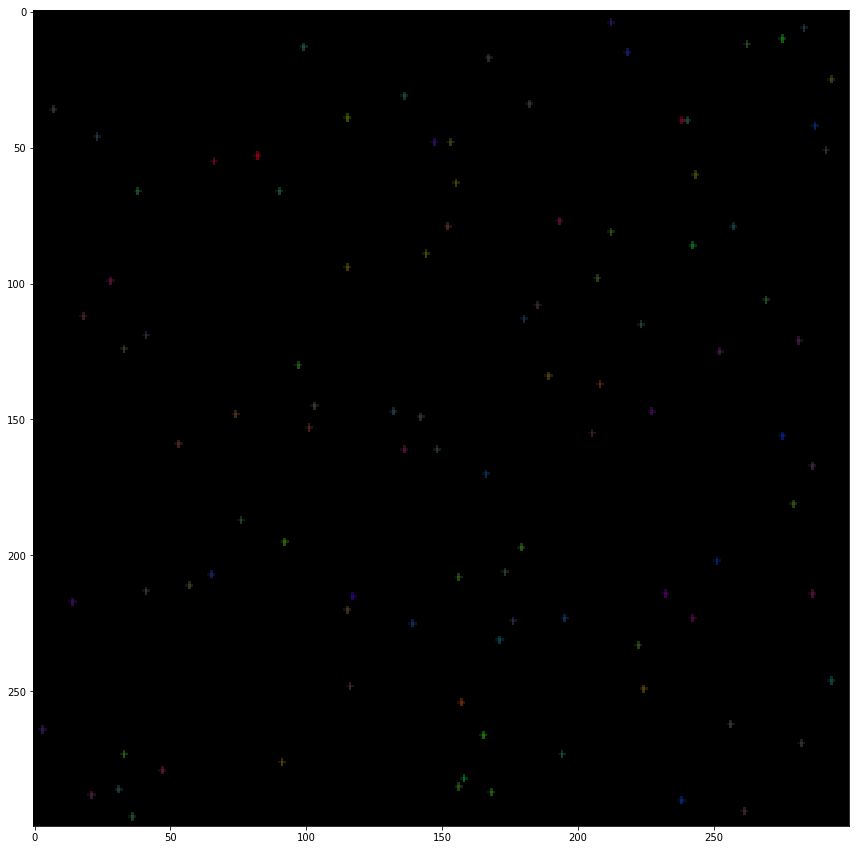

CPU times: user 165 ms, sys: 7.06 ms, total: 172 ms
Wall time: 97.5 ms
CPU times: user 37.4 ms, sys: 681 µs, total: 38.1 ms
Wall time: 8.66 ms


(7.275957614183426e-12, 0.0)

In [25]:
np.random.seed(1)

K = 100
images, centers, seds, morphs = build_scene((3, 300, 300), K, psf, figsize=(15, 15))

%time g_auto = calculate_autograd_gradients(images, centers, seds, morphs)
%time g_analytic = calculate_analytic_gradients(images, centers, seds, morphs)
np.max(np.abs(g_auto[0]-g_analytic[0])), np.max(np.abs(g_auto[1]-g_analytic[1]))

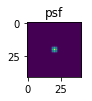

20 20


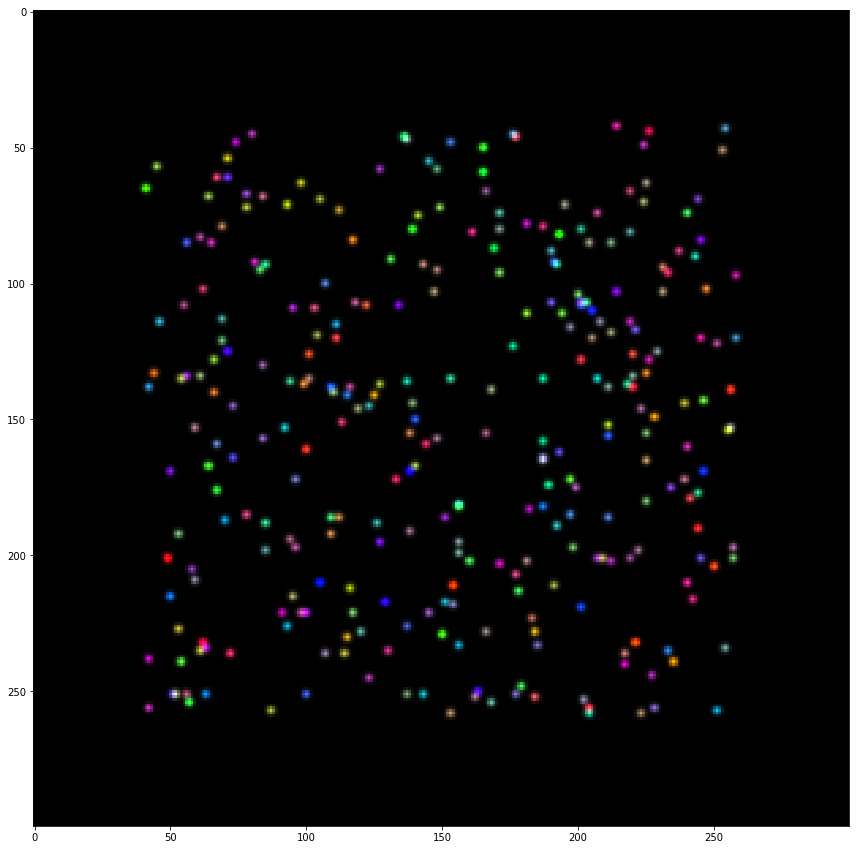

CPU times: user 1.21 s, sys: 7.84 ms, total: 1.22 s
Wall time: 641 ms
CPU times: user 1.02 s, sys: 4.91 ms, total: 1.03 s
Wall time: 459 ms


(2.3283064365386963e-10, 0.0)

In [26]:
np.random.seed(1)

# Initialize a small PSF
units = 0.05
psf = scarlet.gaussian(20, 20, sigma=1, integrate=True, bbox=scarlet.Box((5, 41, 41)))[0]

# get the coords and filter slices needed to 
coords = get_filter_coords(psf)
slices = get_filter_slices(coords.reshape(-1, 2))

plt.figure(figsize=(1,1))
plt.title("psf")
plt.imshow(psf)
plt.show()

K = 300
images, centers, seds, morphs = build_scene((3, 300, 300), K, psf, figsize=(15, 15))

%time g_auto = calculate_autograd_gradients(images, centers, seds, morphs)
%time g_analytic = calculate_analytic_gradients(images, centers, seds, morphs)
np.max(np.abs(g_auto[0]-g_analytic[0])), np.max(np.abs(g_auto[1]-g_analytic[1]))